---
title: "Processing II: Acoustics"
execute:
  warning: false
format: html
toc: true
---


In this script, we extract will work with the audio files we preprocessed in @ADDREF. We will extract the following features:

- intensity
- f0 
- spectral centroid
- voice quality properties such as jitter, shimmer, and harmonics-to-noise ratio
- formants

In [2]:
#| code-fold: true
#| code-summary: Code to load packages and prepare the environment

# packages
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy.signal import butter, filtfilt
import librosa
import parselmouth
import matplotlib.pyplot as plt
import IPython.display as ipd
import seaborn as sns
from scipy.signal import find_peaks, peak_widths

curfolder = os.getcwd()
print(curfolder)

# files to work with
ACfolder = curfolder + '\\..\\01_XDF_processing\\data\\Data_processed\\Data_trials\\Audio_48'

# folders to save the processed data
ACfolder_processed = curfolder + '\\TS_acoustics\\'

actotrack = glob.glob(ACfolder + "/*.wav", recursive=True)
#print(actotrack)

# get rid of the first file because it's faulty
actotrack = actotrack[1:]

e:\FLESH_ContinuousBodilyEffort\03_TS_processing


First, we need to take care that we are not working with wrongly cut audio files, but only with the corrected version (if it exists). From the list of audios, we will hence exclude all files that have also corrected version in the list.

In [3]:
# Get all corrected audios from the list
ac_cor = []
for file in actotrack:
    if 'corrected' in file:
        ac_cor.append(file)

# Now get the name of this trial without the corrected part
ac_old = []
for file in ac_cor:
    ac_old.append(file.replace('_corrected', ''))

# From actotrack, remove trials that are in videos_old
actotrack = [x for x in actotrack if x not in ac_old]

Here is an audio example

In [11]:
#| echo: false

# audio sample
sample = actotrack[10]

ipd.Audio(sample)

And here it is visualized as a waveform

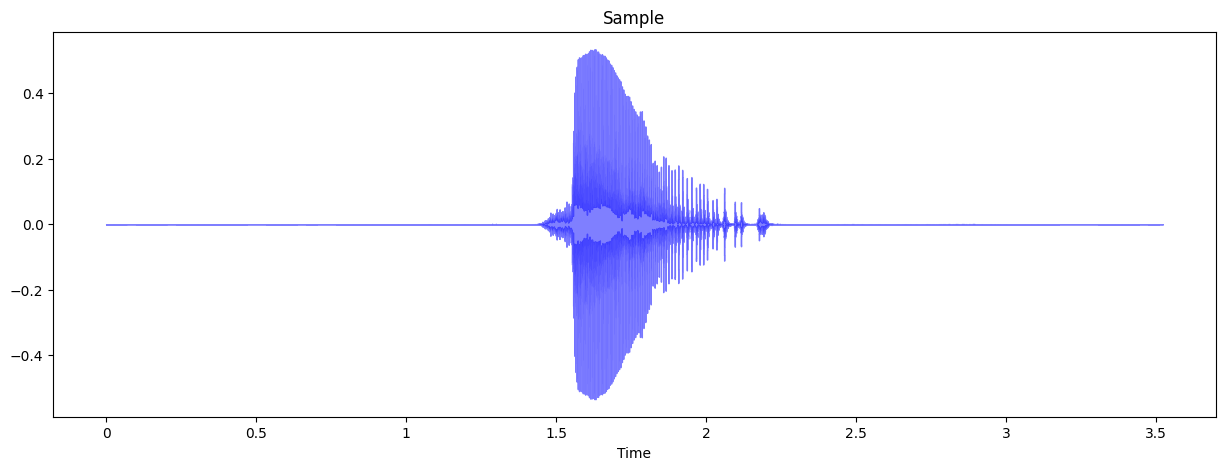

In [12]:
#| echo: false

# visualize the waveform
# from https://www.youtube.com/watch?v=rlypsap6Wow

samp, sr = librosa.load(sample)

plt.figure(figsize=(15, 17))
plt.subplot(3, 1, 1)
librosa.display.waveshow(samp, color='blue', alpha=0.5)   
plt.title('Sample')
plt.show()

In [19]:
#| code-fold: true
#| code-summary: Custom functions

def chunk_and_smooth(df, var, window=25, order=3):

    df['chunk'] = None

    chunk = 0
    for index, row in df.iterrows():
        if np.isnan(row[var]):
            continue
        else:
            df.loc[index, 'chunk'] = chunk
            # if the next value is NaN or this is the last row, increase the chunk
            if index == len(df)-1:
                continue
            elif np.isnan(df.loc[index+1, var]):
                chunk += 1

    # now we can smooth the spectralCent values in each chunk
    chunks = df['chunk'].unique()

    # skip if chunks are empty (that means that there is no var trace)
    if len(chunks) > 1:
        # ignore the first chunk (None)
        chunks = chunks[1:]
        for chunk in chunks:
            # get the rows of the chunk
            chunkrows = df[df['chunk'] == chunk].copy()
            # dont smooth chunks shorter than 5
            if len(chunkrows) < 5:
                continue
            else:
                # smooth var with savgol filter
                chunkrows[var] = scipy.signal.savgol_filter(chunkrows[var], window, order) 
                # put it back to the df
                df.loc[df['chunk'] == chunk, var] = chunkrows[var]

    # get rid of the chunk column
    df = df.drop('chunk', axis=1)

    return df

# Extracting intensity (vocalic energy)

To extract the amplitude envelope of the acoustic signal, we follow a method by @tilsen_arvaniti13, adapted by REF (see [EnvisionBOX](https://www.envisionbox.org/embedded_AnimatingSoundMovement.html)). We use bandpass and 2nd order 10Hz low-pass zero-phase Butterworth filter. 

In [14]:
#| code-fold: true
#| code-summary: Code with functions to extract the amplitude envelope

# Define the bandpass filter
def butter_bandpass(lowcut, highcut, fs, order=2):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filtfilt(data, lowcut, highcut, fs, order=2):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Define the lowpass filter
def butter_lowpass(cutoff, fs, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low')
    return b, a

def butter_lowpass_filtfilt(data, cutoff, fs, order=2):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Function to extract amplitude envelope
def amp_envelope(audiofilename):
    # load audio with librosa
    audio, sr = librosa.load(audiofilename, sr=None, mono=True)
    # Bandpass filter 400-4000Hz
    data = butter_bandpass_filtfilt(audio, 400, 4000, sr, order=2)
    # Lowpass filter 10Hz
    data = butter_lowpass_filtfilt(np.abs(data), 10, sr, order=2)
    # scale from 0 to 1
    data = (data - np.min(data)) / (np.max(data) - np.min(data))
    return data, sr

Here is an example how the vocalic energy is extracted

e:\FLESH_ContinuousBodilyEffort\03_TS_processing\..\01_XDF_processing\data\Data_processed\Data_trials\Audio_48\0_1_trial_3_Mic_nominal_srate48000_p0_vechten_geluiden.wav


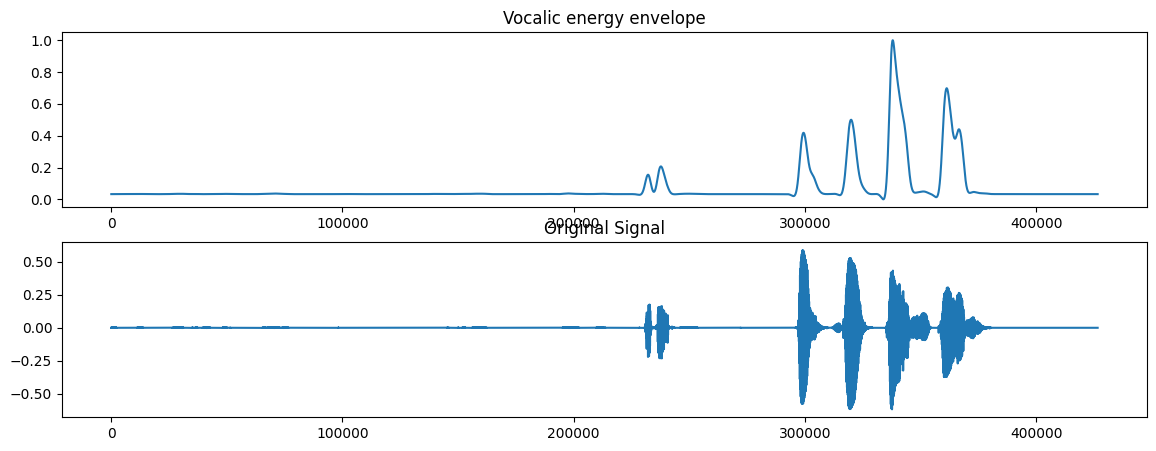

In [15]:
#| echo: false 

# Get the amplitude envelope
audiofilename = actotrack[0]
print(audiofilename)
ampv, sr = amp_envelope(audiofilename)
# Plot the filtered signal and the original signal
plt.figure(figsize=(14, 5))
plt.subplot(2, 1, 1)
plt.plot(ampv)
plt.title('Vocalic energy envelope')

# Extract and plot the original signal
rawaudio, sr = librosa.load(audiofilename, sr=None)
plt.subplot(2, 1, 2)
plt.plot(rawaudio)
plt.title('Original Signal')
plt.show()

Now we loop over all the audio files and extract the vocalic energy

In [16]:
#| eval: false

# Loop over wav files
for audiofile in actotrack:

    # get the trialid
    trialid = audiofile.split('\\')[-1].split('.')[0]
    trialid = '_'.join(trialid.split('_')[0:1] + trialid.split('_')[1:2] + trialid.split('_')[3:4] + trialid.split('_')[7:8])

    print('working on ' + trialid)

    # apply the function
    ampv, sr = amp_envelope(audiofile)

    # Extract and plot the original signal
    rawaudio, sr = librosa.load(audiofile, sr=None)

    # create a time vector
    time_env = np.arange(0, len(rawaudio)/sr, 1/sr)
    
    # Ensure the lengths match by padding ampv if necessary (Note that is a quick fix)
    if len(ampv) < len(time_env):
        ampv = np.pad(ampv, (0, len(time_env) - len(ampv)), mode='constant')
    elif len(ampv) > len(time_env):
        ampv = ampv[:len(time_env)]

    # the same for rawaudio
    if len(rawaudio) < len(time_env):
        rawaudio = np.pad(rawaudio, (0, len(time_env) - len(rawaudio)), mode='constant')
    elif len(rawaudio) > len(time_env):
        rawaudio = rawaudio[:len(time_env)]
    
    # save the audio and envelope
    try:
        audio = pd.DataFrame({'time': time_env, 'audio': rawaudio, 'envelope': ampv, 'trialID': trialid})
        # convert time to ms
        audio['time'] = audio['time'] * 1000

        # perform also envelope change
        audio['envelope_change'] = np.insert(np.diff(audio['envelope']), 0, 0)
        # smooth
        audio['envelope_change'] = butter_lowpass_filtfilt(np.abs(audio['envelope_change']), 10, sr, order=2)
        
        # write as csv
        audio.to_csv(ACfolder_processed + '/env_' + trialid + '.csv', index=False)

    except ValueError:
        print('ValueError: ' + trialid)
        continue

working on 0_1_3_p0
working on 0_1_4_p0
working on 0_1_5_p0
working on 0_1_6_p0
working on 0_1_7_p0
working on 0_1_11_p1
working on 0_1_12_p1
working on 0_1_13_p1
working on 0_1_14_p1
working on 0_1_15_p1
working on 0_1_16_p1
working on 0_1_17_p1
working on 0_1_19_p0
working on 0_1_20_p0
working on 0_1_21_p0
working on 0_1_22_p0
working on 0_1_23_p0
working on 0_1_24_p0
working on 0_1_25_p0
working on 0_1_26_p0
working on 0_1_27_p1
working on 0_1_28_p1
working on 0_1_29_p1
working on 0_1_30_p1
working on 0_1_31_p1
working on 0_1_32_p1
working on 0_1_33_p1
working on 0_1_34_p1
working on 0_1_35_p1
working on 0_1_36_p0
working on 0_1_37_p0
working on 0_1_38_p0
working on 0_1_39_p0
working on 0_1_40_p0
working on 0_1_41_p0
working on 0_1_42_p0
working on 0_1_43_p0
working on 0_1_44_p0
working on 0_1_45_p1
working on 0_1_46_p1
working on 0_1_47_p1
working on 0_1_48_p1
working on 0_1_49_p1
working on 0_1_50_p1
working on 0_1_51_p1
working on 0_1_52_p1
working on 0_1_53_p1
working on 0_1_1_p

This is an example of a file

In [17]:
#| echo: false

# envfiles
envfiles = glob.glob(ACfolder_processed + "/env_*.csv", recursive=True)

# sample
audio = pd.read_csv(envfiles[0])

# display
audio.head(15)

,time,audio,envelope,trialID,envelope_change
0,0.000000,-0.000031,0.016587,0_1_18_p0,-4.792690e-09
1,0.020833,-0.000031,0.016587,0_1_18_p0,-4.779707e-09
2,0.041667,-0.000031,0.016587,0_1_18_p0,-4.766729e-09
3,0.062500,-0.000031,0.016587,0_1_18_p0,-4.753755e-09
4,0.083333,-0.000031,0.016587,0_1_18_p0,-4.740787e-09
5,0.104167,-0.000031,0.016587,0_1_18_p0,-4.727823e-09
6,0.125000,-0.000031,0.016587,0_1_18_p0,-4.714864e-09
7,0.145833,-0.000031,0.016587,0_1_18_p0,-4.701909e-09
8,0.166667,-0.000031,0.016587,0_1_18_p0,-4.688959e-09
9,0.187500,-0.000031,0.016587,0_1_18_p0,-4.676015e-09


Here it is visualized

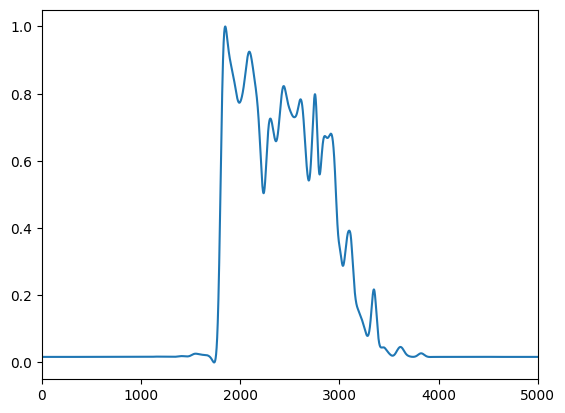

In [18]:
#| echo: false

# plot to check
plt.plot(audio['time'], audio['envelope'])
plt.xlim(0, 5000)
plt.show()

# Extracting fundamental frequency (f0)

Now we extract pitch using the `parselmouth` library. 

Because we need take into consideration the sex of participant to set the f0 range accordingly, prior to this script we have extracted the speakers' register using Praat script `Get_Speakers_register.praat` from Celine De Looze and save it in file *SpekaerRegister.txt*. 

Now, we first check the mean min and max f0 values across all available data and set the range accordingly.

In [8]:
# this is where we store the min-max f0 values of each speaker
register = pd.read_csv(curfolder + '\\SpeakerRegister.txt', sep='\t') 

# here we store metadata for each session about sex
meta = pd.read_csv(curfolder + '\\..\\00_RAWDATA\\META_gender.txt', sep='\t')

# now we want to find out the range for males and females
register['sex'] = None

# make f0min and f0max numeric
register['f0min'] = pd.to_numeric(register['f0min'], errors='coerce')
register['f0max'] = pd.to_numeric(register['f0max'], errors='coerce')

# loop over rows in register,
for idx, row in register.iterrows():
    #  get sessionID from FILE (first part)
    sessionID = row['FILE'].split('_')[0]
    # get pcn id
    pcn = row['FILE'].split('_')[7]
    # merge it
    ID = sessionID + '_' + pcn
    # find this id in meta and save in sex the value in column sex
    sex = meta[meta['ID'] == ID]['sex'].values[0]
    # save value of sex in current row
    register.at[idx, 'sex'] = sex

# now group sex by each value and find the mean of f0min and f0max
f0min = register.groupby('sex')['f0min'].min()
f0max = register.groupby('sex')['f0max'].mean()
print(f0min, f0max)
    


sex
f    22.0
Name: f0min, dtype: float64 sex
f    380.660131
Name: f0max, dtype: float64


Dyad 0 consists of two females, and the f0 min is 22 Hz and f0 maxis 381 Hz.

In [18]:
#| code-fold: true
#| code-summary: Code with function to extract the fundamental frequency

def extract_f0(locationsound, sex):

    # read the sound file as numpy array
    audio, sr = librosa.load(locationsound, sr=48000)

    # read the sound file into Python
    snd = parselmouth.Sound(audio, sampling_frequency=sr)

    if sex == 'f':
        f0min = 22      ## calculated by previous chunk
        f0max = 381
    else:
        f0min = 30      ## Note: don't have any males in dyad0 so this is only placeholder
        f0max = 650

    pitch = snd.to_pitch(time_step = 0.002, pitch_floor=f0min, pitch_ceiling=f0max) #time_step to get 500Hz

    f0_values = pitch.selected_array['frequency']

    return snd, f0_values

Now we loop over all audio files and extract f0 from each. Resulting f0 contours were smoothed with
a Savitzky-Golay 3rd-polynomial filter with a span of 50 ms (following @ADDREF) applied to continuous runs of phonated vocalization to maintain discontinuities typical of the f0 signal. 

In [21]:
#| eval: false

freq=48000    
meta = pd.read_csv(curfolder + '\\..\\00_RAWDATA\\META.txt', sep='\t')

# Loop over wav files
for audiofile in actotrack:

    # get the trialid
    trialid = audiofile.split('\\')[-1].split('.')[0]
    #trial id is the first, second, fourth and eighth element
    trialid = '_'.join(trialid.split('_')[0:1] + trialid.split('_')[1:2] + trialid.split('_')[3:4] + trialid.split('_')[7:8])

    print('working on ' + trialid)

    # first element is sessionid, fourth element is participantid
    sessionid = trialid.split('_')[0]
    participantid = trialid.split('_')[3]
    ID = sessionid + '_' + participantid

    # what sex has this ID in meta
    sex = meta[meta['ID'] == ID]['sex'].values[0]

    # apply the function
    snd, f0 = extract_f0(audiofile, sex)

    length = len(f0)

    # replace 0 values with NaN
    f0 = np.where(f0 == 0, np.nan, f0)

    # create time vector
    F0_time = np.linspace(0, snd.duration, len(f0)) * 1000  # Generate time vector

    # create df
    f0_df = pd.DataFrame({'time_ms': F0_time, 'f0': f0, 'ID': trialid})

    # Smooth the f0 values
    try:
        f0_df = chunk_and_smooth(f0_df, 'f0') # do it with window 25
    except ValueError:
        # unless there is only tiny chunk of f0 and then we need window of 5
        print('ValueError: ' + trialid + ', f0 trace is smaller than window length, resuming to window=5')
        f0_df = chunk_and_smooth(f0_df, 'f0', window=5)

    # write as csv
    f0_df.to_csv(ACfolder_processed + '/f0_' + trialid + '.csv', index=False)


working on 0_1_3_p0
working on 0_1_4_p0
working on 0_1_5_p0
working on 0_1_6_p0
working on 0_1_7_p0
working on 0_1_11_p1
working on 0_1_12_p1
working on 0_1_13_p1
working on 0_1_14_p1
working on 0_1_15_p1
working on 0_1_16_p1
ValueError: 0_1_16_p1, f0 trace is smaller than window length, resuming to window=5
working on 0_1_17_p1
working on 0_1_19_p0
working on 0_1_20_p0
working on 0_1_21_p0
working on 0_1_22_p0
ValueError: 0_1_22_p0, f0 trace is smaller than window length, resuming to window=5
working on 0_1_23_p0
working on 0_1_24_p0
ValueError: 0_1_24_p0, f0 trace is smaller than window length, resuming to window=5
working on 0_1_25_p0
working on 0_1_26_p0
working on 0_1_27_p1
ValueError: 0_1_27_p1, f0 trace is smaller than window length, resuming to window=5
working on 0_1_28_p1
ValueError: 0_1_28_p1, f0 trace is smaller than window length, resuming to window=5
working on 0_1_29_p1
working on 0_1_30_p1
working on 0_1_31_p1
working on 0_1_32_p1
working on 0_1_33_p1
working on 0_1_34_

Here is an example of a file

In [22]:
#| echo: false

# envfiles
f0files = glob.glob(ACfolder_processed + "/f0_*.csv", recursive=True)

# sample
audio = pd.read_csv(f0files[0])

# display
audio.head(15)

,time_ms,f0,ID
0,0.000000,NaN,0_1_10_p1
1,2.052699,NaN,0_1_10_p1
2,4.105398,NaN,0_1_10_p1
3,6.158097,NaN,0_1_10_p1
4,8.210796,NaN,0_1_10_p1
5,10.263495,NaN,0_1_10_p1
6,12.316194,NaN,0_1_10_p1
7,14.368892,NaN,0_1_10_p1
8,16.421591,NaN,0_1_10_p1
9,18.474290,NaN,0_1_10_p1


And here visualized

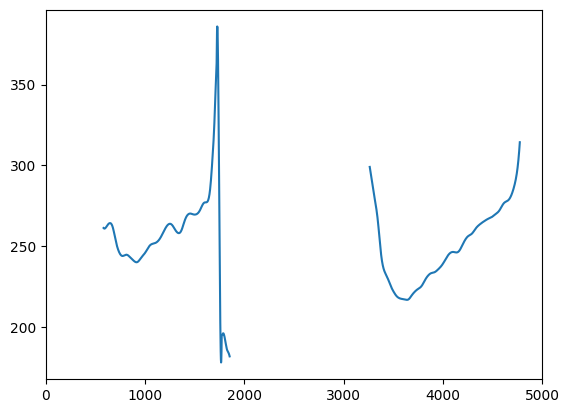

In [23]:
#| echo: false

# plot to check
plt.plot(audio['time_ms'], audio['f0'])
plt.xlim(0, 5000)
plt.show()

# Extracting spectral centroid

To extract the are of the main spectral energy, we will compute spectral centroid / spectral center of gravity using `parselmouth` package. We are filtering out the fundamental frequency (F0) to remove low-frequency components that might interfere with the analysis (code adapted from [here](https://se.mathworks.com/matlabcentral/fileexchange/104555-digital-signal-processing-system-analysis-and-design?focused=b988de35-99f5-4f66-a67f-c014b9c170b1&tab=function)).

In [25]:
#| code-fold: true
#| code-summary: Code with function to filter out f0

from scipy.signal import sosfilt

def remove_f0(x, fundamental, fs):
    # Normalize the frequency for digital filter design
    f_dig = 2 * np.pi * fundamental / fs
    
    # Define the notch filter parameters for F0
    p1 = 0.999 * np.exp(1j * f_dig)  # Pole near the F0 frequency
    z1 = np.exp(1j * f_dig)          # Zero near the F0 frequency
    
    # Define zeros and poles for the notch filter
    zeros = np.array([z1, z1])
    poles = np.array([p1, p1])
    
    # Create a 2nd-order section (sos) filter array
    sos = np.array([[1, -2 * np.real(p1), 1, 1, -2 * np.real(z1), np.abs(z1)**2]])

    # Apply the notch filter to the signal
    y = sosfilt(sos, x)
    
    return y

In [42]:
#| eval: false

# Parameters
window_length = 0.03 # 30ms analysis window

# Loop over wav files
for audiofile in actotrack:
    # Extract trial ID from filename
    trialid = os.path.basename(audiofile).split('.')[0]
    trialid = '_'.join(trialid.split('_')[0:1] + trialid.split('_')[1:2] + trialid.split('_')[3:4] + trialid.split('_')[7:8])

    print(f'Working on {trialid}')

    # Extract session and participant ID
    sessionid = trialid.split('_')[0]
    participantid = trialid.split('_')[3]
    ID = f"{sessionid}_{participantid}"

    # Load sound
    snd = parselmouth.Sound(audiofile)

    # Get sampling rate
    fs = snd.sampling_frequency

    # Load f0 file with the same trialid
    f0file = ACfolder_processed + '/f0_' + trialid + '.csv'
    f0_df = pd.read_csv(f0file)

    # Get the mean (from non-NaN values) of the f0
    f0_df = f0_df.dropna()
    mean_f0 = f0_df['f0'].mean()

    # Sound values
    sound_values = snd.values[0]

    # Remove F0 from the signal using the mean F0
    filtered_signal = remove_f0(sound_values, mean_f0, fs)

    # Recreate the sound object with the filtered signal
    filtered_sound = parselmouth.Sound(filtered_signal, sampling_frequency=fs)

    # Compute spectrogram of the filtered signal
    spectrogram = filtered_sound.to_spectrogram(window_length=window_length)

    # Extract time values from the spectrogram
    times = spectrogram.xs()  # Time vector in seconds

    # Compute CoG for each time step
    cog_values = [spectrogram.to_spectrum_slice(time=t).get_centre_of_gravity(power=2.0) for t in times]

    # Convert time to milliseconds
    time_cog = np.array(times) * 1000  

    # Convert CoG values to numpy array
    cog_values = np.array(cog_values)

    # Create DataFrame
    cog_df = pd.DataFrame({'time': time_cog, 'CoG': cog_values, 'TrialID': trialid})

    # Replace zeros with NaN
    cog_df['CoG'] = cog_df['CoG'].replace(0, np.nan)

    # Smooth the data
    try:
        cog_df = chunk_and_smooth(cog_df, 'CoG')
    except ValueError:
        print(f'ValueError: {trialid}, CoG trace is smaller than window length, using window=5')
        cog_df = chunk_and_smooth(cog_df, 'CoG', window=5)

    # Save DataFrame
    output_path = os.path.join(ACfolder_processed, f'cog_{trialid}.csv')
    cog_df.to_csv(output_path, index=False)


Working on 0_1_3_p0
Working on 0_1_4_p0
Working on 0_1_5_p0
Working on 0_1_6_p0
Working on 0_1_7_p0
Working on 0_1_11_p1
Working on 0_1_12_p1
Working on 0_1_13_p1
Working on 0_1_14_p1
Working on 0_1_15_p1
Working on 0_1_16_p1
Working on 0_1_17_p1
Working on 0_1_19_p0
Working on 0_1_20_p0
Working on 0_1_21_p0
Working on 0_1_22_p0
Working on 0_1_23_p0
Working on 0_1_24_p0
Working on 0_1_25_p0
Working on 0_1_26_p0
Working on 0_1_27_p1
Working on 0_1_28_p1
Working on 0_1_29_p1
Working on 0_1_30_p1
Working on 0_1_31_p1
Working on 0_1_32_p1
Working on 0_1_33_p1
Working on 0_1_34_p1
Working on 0_1_35_p1
Working on 0_1_36_p0
Working on 0_1_37_p0
Working on 0_1_38_p0
Working on 0_1_39_p0
Working on 0_1_40_p0
Working on 0_1_41_p0
Working on 0_1_42_p0
Working on 0_1_43_p0
Working on 0_1_44_p0
Working on 0_1_45_p1
Working on 0_1_46_p1
Working on 0_1_47_p1
Working on 0_1_48_p1
Working on 0_1_49_p1
Working on 0_1_50_p1
Working on 0_1_51_p1
Working on 0_1_52_p1
Working on 0_1_53_p1
Working on 0_1_1_p

This is a visual example of a file

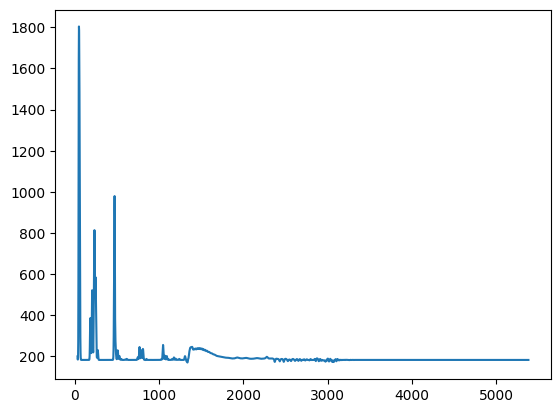

In [45]:
#| echo: false

cogfiles = glob.glob(ACfolder_processed + "/cog_*.csv", recursive=True)
sample = pd.read_csv(cogfiles[50])

# Plot
plt.plot(sample['time'], sample['CoG'])
plt.show()

# Extracting formants

To extract formant values, we use Chris Carignan's Praat script (see [Github](https://github.com/ChristopherCarignan/formant-optimization)) which optimizes the F1-F5 values.

To verify the sensibility of the data, we will do some visual inspections. Moreover, we will consider taking formant values from the windows of envelope amplitude peaks.

In [28]:
#| code-fold: true
#| code-summary: Code to prepare the environment

# Here we store formants from praat
formantfolder = curfolder + '/TS_formants/Carignan_formants/'
formants = glob.glob(formantfolder + '*.Table')

# Here we store processed envelope 
envfiles = glob.glob(ACfolder_processed + '/env_*.csv')

Chris Carignan's Praat-script outputs formants as a .Table. Let's therefore first read these files and resave them as .csv files. 

In [29]:
#| eval: false

for formant in formants:
    formant_df = pd.read_csv(formant, sep='\t')

    # get the name of the file
    filename = os.path.basename(formant)
    # get the name of the file without the extension
    filename = os.path.splitext(filename)[0]

    # add to df
    formant_df['filename'] = filename

    # get trialid from the file name 
    trialid = '_'.join(filename.split('_')[0:2] + filename.split('_')[3:4] + filename.split('_')[7:8]) 

    print('working on ' + trialid)

    # add empty row in the beginning with time 0 and rest as first row
    copy_row = formant_df.iloc[0].copy()
    # time of this row is 0
    copy_row['time'] = 0

    # add this row to the beginning of the df
    formant_df = pd.concat([pd.DataFrame(copy_row).T, formant_df], ignore_index=True)
    
    # add trialid to the df
    formant_df['trialid'] = trialid

    # write it as csv to formantfolder1
    formant_df.to_csv(ACfolder_processed + 'praat_formants_' + trialid + '.csv', index=False)

working on 0_2_0_p0
working on 0_2_19_p1
working on 0_2_1_p0
working on 0_2_20_p1
working on 0_2_21_p1
working on 0_2_22_p1
working on 0_2_38_p0
working on 0_2_39_p0
working on 0_2_40_p0
working on 0_2_53_p1
working on 0_2_54_p1
working on 0_2_55_p1
working on 0_2_56_p1
working on 0_2_67_p0
working on 0_2_68_p0
working on 0_2_69_p0
working on 0_2_70_p0
working on 0_2_71_p0
working on 0_2_72_p0
working on 0_2_92_p1
working on 0_2_93_p1
working on 0_2_94_p1
working on 0_2_95_p1
working on 0_2_96_p1
working on 0_2_97_p1
working on 0_2_100_p1
working on 0_2_101_p1
working on 0_2_102_p1
working on 0_2_103_p1
working on 0_2_104_p1
working on 0_2_105_p1
working on 0_2_106_p1
working on 0_2_107_p1
working on 0_2_108_p1
working on 0_2_109_p1
working on 0_2_10_p0
working on 0_2_110_p1
working on 0_2_111_p1
working on 0_2_112_p1
working on 0_2_113_p1
working on 0_2_11_p0
working on 0_2_12_p0
working on 0_2_13_p0
working on 0_2_14_p0
working on 0_2_15_p0
working on 0_2_16_p0
working on 0_2_17_p0
w

In [30]:
#| output: false

# inititate empty df
formants_df = pd.DataFrame()

# get all formant files we just created
formantfiles = glob.glob(ACfolder_processed + 'praat_formants_*.csv')

# loop over formants 2 and make a giga df from all
for formant in formantfiles:
    print('working on ' + formant)
    for_df = pd.read_csv(formant)

    # get the name of the file
    filename = for_df['filename'][0]

    # in filename, look for c1, c2, c0
    if 'c1' in filename:
        for_df['correction'] = 'c1'
    elif 'c2' in filename:
        for_df['correction'] = 'c2'
    elif 'c0' in filename:
        for_df['correction'] = 'c0'
    else:
        for_df['correction'] = 'none'
    
    # concatenate
    formants_df = pd.concat([formants_df, for_df])

# get rid of rows with correction = none
formants_df = formants_df[formants_df['correction'] != 'none']

working on e:\FLESH_ContinuousBodilyEffort\03_TS_processing\TS_acoustics\praat_formants_0_2_0_p0.csv
working on e:\FLESH_ContinuousBodilyEffort\03_TS_processing\TS_acoustics\praat_formants_0_2_19_p1.csv
working on e:\FLESH_ContinuousBodilyEffort\03_TS_processing\TS_acoustics\praat_formants_0_2_1_p0.csv
working on e:\FLESH_ContinuousBodilyEffort\03_TS_processing\TS_acoustics\praat_formants_0_2_20_p1.csv
working on e:\FLESH_ContinuousBodilyEffort\03_TS_processing\TS_acoustics\praat_formants_0_2_21_p1.csv
working on e:\FLESH_ContinuousBodilyEffort\03_TS_processing\TS_acoustics\praat_formants_0_2_22_p1.csv
working on e:\FLESH_ContinuousBodilyEffort\03_TS_processing\TS_acoustics\praat_formants_0_2_38_p0.csv
working on e:\FLESH_ContinuousBodilyEffort\03_TS_processing\TS_acoustics\praat_formants_0_2_39_p0.csv
working on e:\FLESH_ContinuousBodilyEffort\03_TS_processing\TS_acoustics\praat_formants_0_2_40_p0.csv
working on e:\FLESH_ContinuousBodilyEffort\03_TS_processing\TS_acoustics\praat_forma

This is how the formants look like in a table

In [31]:
#| echo: false

formants_df.head(15)

,time,f1,f2,f3,f4,f5,filename,trialid,correction
0,0.000000,1910.072640,3380.992452,5896.442699,0.0,0.0,0_2_pr_0_Mic_nominal_srate48000_p0_juichen_com...,0_2_0_p0,c0
1,0.026031,1910.072640,3380.992452,5896.442699,0.0,0.0,0_2_pr_0_Mic_nominal_srate48000_p0_juichen_com...,0_2_0_p0,c0
2,0.031031,1890.080560,3366.165092,5896.610205,0.0,0.0,0_2_pr_0_Mic_nominal_srate48000_p0_juichen_com...,0_2_0_p0,c0
3,0.036031,1910.066181,3380.974399,5896.442306,0.0,0.0,0_2_pr_0_Mic_nominal_srate48000_p0_juichen_com...,0_2_0_p0,c0
4,0.041031,1890.092319,3366.156404,5896.609863,0.0,0.0,0_2_pr_0_Mic_nominal_srate48000_p0_juichen_com...,0_2_0_p0,c0
5,0.046031,1910.073207,3380.962077,5896.441999,0.0,0.0,0_2_pr_0_Mic_nominal_srate48000_p0_juichen_com...,0_2_0_p0,c0
6,0.051031,1890.087965,3366.149616,5896.609697,0.0,0.0,0_2_pr_0_Mic_nominal_srate48000_p0_juichen_com...,0_2_0_p0,c0
7,0.056031,1910.062802,3380.953514,5896.441903,0.0,0.0,0_2_pr_0_Mic_nominal_srate48000_p0_juichen_com...,0_2_0_p0,c0
8,0.061031,1890.085211,3366.138214,5896.609723,0.0,0.0,0_2_pr_0_Mic_nominal_srate48000_p0_juichen_com...,0_2_0_p0,c0
9,0.066031,1910.063561,3380.941686,5896.442068,0.0,0.0,0_2_pr_0_Mic_nominal_srate48000_p0_juichen_com...,0_2_0_p0,c0


This is how the formants look for a single trial.

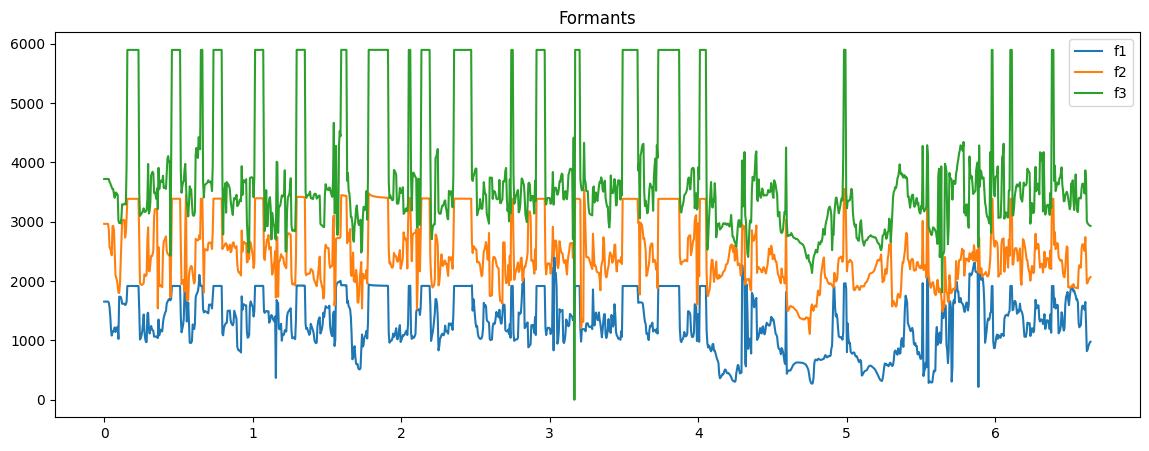

In [32]:
#| echo: false

# pick a random trialid from formants1_df
trialid = formants_df['trialid'].sample(1).values[0]

# get the formants for this trialid from both dfs
formants1_trial = formants_df[formants_df['trialid'] == trialid]

# plot the formants as time series
plt.figure(figsize=(14, 5))
plt.plot(formants1_trial['time'], formants1_trial['f1'], label='f1')
plt.plot(formants1_trial['time'], formants1_trial['f2'], label='f2')
plt.plot(formants1_trial['time'], formants1_trial['f3'], label='f3')
plt.title('Formants')
plt.legend()
plt.show()

Now let's look at the vowel space area across all data.

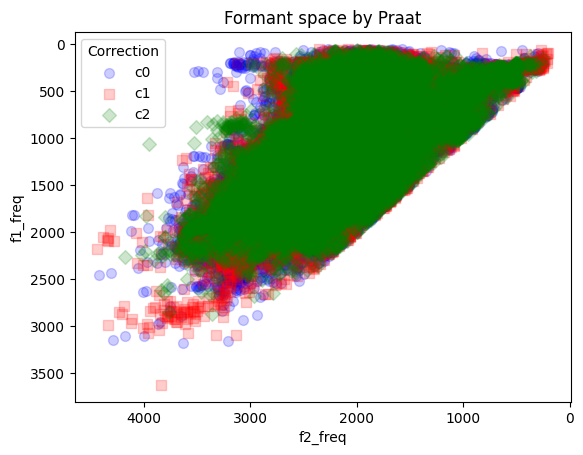

In [33]:
#| echo: false

# Define the color and shape mapping for each unique correction
color_mapping = {'c0': 'blue', 'c1': 'red', 'c2': 'green'}
shape_mapping = {'c0': 'o', 'c1': 's', 'c2': 'D'}  # 'o' = circle, 's' = square, 'D' = diamond

# Create the plot
for correction in formants_df['correction'].unique():
    subset = formants_df[formants_df['correction'] == correction]
    plt.scatter(subset['f2'], subset['f1'],
                color=color_mapping[correction],
                marker=shape_mapping[correction],
                s=50,
                label=correction,
                alpha=0.2)

# Reverse axes
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

# Labels
plt.xlabel('f2_freq')
plt.ylabel('f1_freq')

# title
plt.title('Formant space by Praat')

# Add legend for colors and shapes
plt.legend(title="Correction")
plt.show()


And this is distribution of f1 across all data.

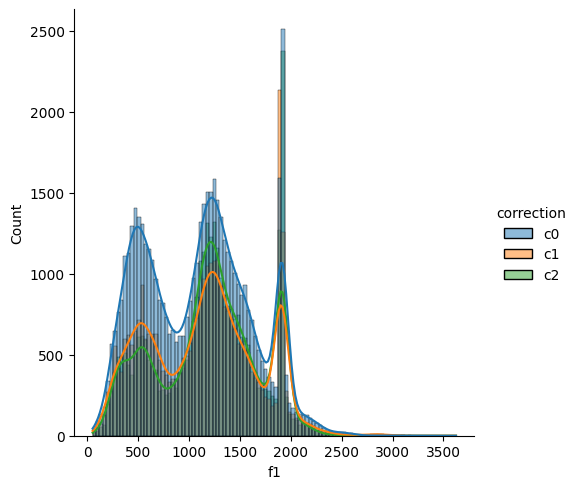

In [34]:
#| echo: false

# correction as factor
formants_df['correction'] = pd.Categorical(formants_df['correction'])

# reset index
df_results = formants_df.reset_index(drop=True)

# plot desnity of f1_freq , each correction separately
sns.displot(data=df_results, x='f1', hue='correction', fill=True, kde=True)

This all looks reasonable. However, we should still be careful. Formant values are most reliable where f0 is present. Since in this project, we work with non-speech sounds, they are frequently unvoiced. Because research shows that there are also formants beyond f0 contour (REF-RAPH), we will also consider formant values in the moments of envelope peaks. This will maximize the number of data points we can use for analysis.

We can use `findpeaks()` function from the `signal` package to find the peaks in the envelope. We can then use these peaks as a reference point for formant extraction.

In [35]:
env_df = pd.DataFrame()

# loop over env files and make a giga df from all
for envfile in envfiles:
    df = pd.read_csv(envfile)
    env_df = pd.concat([env_df, df])

Using `peak_width` function, we can extract the window of an envelope peak. Further, we can define the relative height of the peak to adjust the window size. Here, we try relative height of 0.5 and 0.9

In [36]:
# rename trialID to trialid
env_df = env_df.rename(columns={'trialID': 'trialid'})

# pick a random trialid from env_df
trialid = '0_2_62_p1'

# get the env for this trialid from env_df
env_trial = env_df[env_df['trialid'] == trialid]

# find peaks, min height is mean of the env
peaks, _ = find_peaks(env_trial['envelope'], height=np.mean(env_df['envelope']))

# get the width of the peaks
results_half = peak_widths(env_trial['envelope'], peaks, rel_height=0.5)
results_full = peak_widths(env_trial['envelope'], peaks, rel_height=0.9)

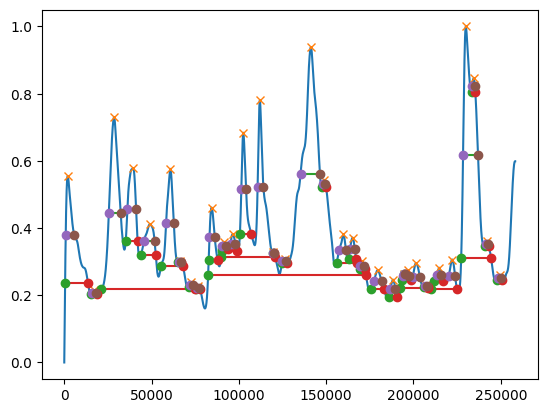

In [37]:
#| echo: false

# plot the env as time series
plt.plot(env_trial['envelope'])
# plot the peaks
plt.plot(peaks, env_trial['envelope'][peaks], "x")
# plot the width of the peaks
plt.hlines(*results_full[1:], color="C3")
# plot the start and end of the peaks
plt.plot(results_full[2], env_trial['envelope'][results_full[2].astype(int)], "o")
plt.plot(results_full[3], env_trial['envelope'][results_full[3].astype(int)], "o")
# show also half width
plt.hlines(*results_half[1:], color="C2")
plt.plot(results_half[2], env_trial['envelope'][results_half[2].astype(int)], "o")
plt.plot(results_half[3], env_trial['envelope'][results_half[3].astype(int)], "o")

plt.show()

Now we can check envelope peak widths against formant values. In merged dataframe with both formants and envelope, we will annotate peak widths, so that we know which values of formants to consider (the rest we turn to NA)

In [38]:
# find formants2 df with the same trialid
formants_trial = formants_df[formants_df['trialid'] == trialid]

# convert time to ms
formants_trial['time'] = formants_trial['time'] * 1000

# merge formants1 and formants2 on trialid and time, outer method
merged_df = pd.merge(env_trial, formants_trial, on=['trialid', 'time'], how='outer')

# cols to int
colstoint = ['f1', 'f2', 'f3', 'f4', 'f5']

#interpolate 
for col in colstoint:
    merged_df[col] = merged_df[col].interpolate(method='linear', x = merged_df['time'])

#delete rows where envelope is NaN
merged_df = merged_df.dropna(subset=['envelope'])

# check the width of the peaks
peaks, _ = find_peaks(merged_df['envelope'], height=np.mean(env_df['envelope'])) # minimum height of the peak is mean of the envelope (across all data)

# get the width of the peaks
results_width = peak_widths(merged_df['envelope'], peaks, rel_height=0.9)

# create column peak_width and put 1 everywhere between start and end of the peak
merged_df['peak_width'] = 0

# create a table from the results_half[2] and results_half[3]
peak_w = pd.DataFrame({'start': results_width[2], 'end': results_width[3]})

# loop over the rows of the peak_w and put 1 in the peak_width column between start and end
for i, row in peak_w.iterrows():
    merged_df.loc[row['start']:row['end'], 'peak_width'] = 1

# for each formant column, create new f_clean column and put the value of the formant where peak_width = 1
for col in colstoint:
    merged_df[col + '_clean'] = merged_df[col] * merged_df['peak_width']
    #instead of 0, put NaN
    merged_df[col + '_clean'] = merged_df[col + '_clean'].replace(0, np.nan)


C:\Users\Sarka Kadava\AppData\Local\Temp\ipykernel_21516\958394636.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  formants_trial['time'] = formants_trial['time'] * 1000


Here we can see visualized overlap of formants and envelope (peaks). The darker part of the formants signal is the window of an envelope peak.

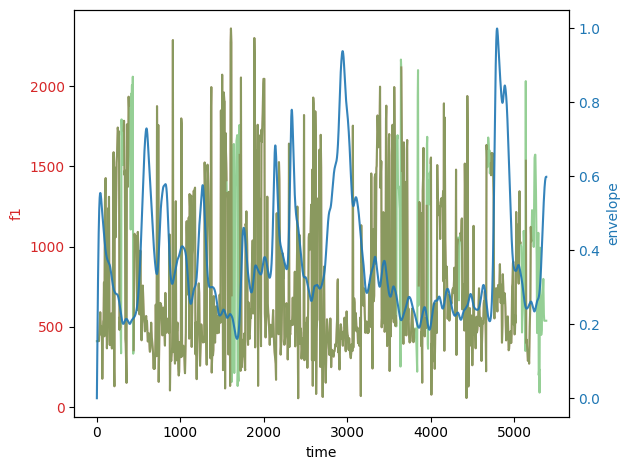

In [39]:
#| echo: false

fig, ax1 = plt.subplots()

color = 'tab:red'
color1 = 'tab:green'
ax1.set_xlabel('time')
ax1.set_ylabel('f1', color=color)

ax1.plot(merged_df['time'], merged_df['f1_clean'], color=color, alpha=0.5)
ax1.plot(merged_df['time'], merged_df['f1'], color=color1, alpha=0.5)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'

ax2.set_ylabel('envelope', color=color)
ax2.plot(merged_df['time'], merged_df['envelope'], color=color, alpha=0.9)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()


In script @ADD, we will get back to this and use both envelope peaks and f0 to define the relevant formant windows.